In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
sys.setrecursionlimit(100000)
def rec_dd():
    return defaultdict(rec_dd)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats
from matplotlib.transforms import Bbox


# function

In [2]:
def plot_ax(data, ax, x_axis="resolution", y_axis="error", title="", legend=True, color="red", regplot=True, label="", x_pos=0.05, y_pos=0.95):
    ax.scatter(
        data[x_axis],
        data[y_axis],
        c=color,
        s=30,
        label=label,
    )
    r_value = stats.pearsonr(data[x_axis], data[y_axis]).statistic

    if regplot:
        # Compute the regression line manually
        slope, intercept, _, _, _ = stats.linregress(data[x_axis], data[y_axis])
        # Extend the regression line across the entire x-axis
        x_range = np.linspace(data[x_axis].min(), data[x_axis].max(), 500)
        y_range = slope * x_range + intercept

        ax.plot(
            x_range,
            y_range,
            color=color,
            linestyle="--",
            label=f"Regression Line {label}",
        )

    # Add the R-value as text on the plot
    ax.text(
        x_pos, y_pos,  # Position (adjust based on your plot)
        f"$r = {r_value:.2f}$",  # Format the R-value to 2 decimal places
        transform=ax.transAxes,  # Coordinate system for text placement
        verticalalignment='top',
        fontsize=70
    )
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    if legend :
        ax.set_title(title)
        ax.legend()
        ax.legend(loc='upper right')
    return ax


# Read data

In [3]:
total_summary_epitope=pd.read_csv(
    "/home/gabrielathenes/Documents/all_structures/error_summary_250212_antigen.csv"
)
total_summary_paratope=pd.read_csv("/home/gabrielathenes/Documents/all_structures/error_summary_250212_antibody.csv")

data = pd.read_csv(
    "/home/gabrielathenes/Documents/all_structures/sabdab_summary_all.tsv",
    sep="\t",
)
print(len(data["pdb"].unique()))
data = data.query("resolution not in(['NOT','3.9, 3.9','8.9, 8.9'])")
data = data.astype({"resolution": float})
data = data.query(
    "antigen_type.isin(['peptide','protein'])"
)
print(len(data["pdb"].unique()))
data=data.dropna(subset=["Hchain", "Lchain"])
nanobodies = data[(data["Hchain"].str.contains(r'[a-z]') | data["Lchain"].str.contains(r'[a-z]'))]["pdb"].unique()
data=data.query("pdb not in @nanobodies")
print(len(data["pdb"].unique()))
data["group_size"] = data.groupby("pdb")["pdb"].transform('size')
data=data.query("group_size==2")
print(len(data["pdb"].unique()))

aacdb = pd.read_csv('/home/gabrielathenes/Documents/all_structures/antigen_antibody_data.csv')
duplicated_pdbs = aacdb.groupby("pdb").agg({"antibody": "nunique", "protein": "nunique"})
duplicated_pdbs = duplicated_pdbs[(duplicated_pdbs["antibody"] > 1) | (duplicated_pdbs["protein"] > 1)].index
result = aacdb[aacdb["pdb"].isin(duplicated_pdbs)]
pdbs = result["pdb"].str.lower().unique()

data=data.query("pdb not in @pdbs")
print(len(data["pdb"].unique()))


8697
5314
4051
1228
1122


In [4]:
for column in ['distance', 'error','error_normalized', 'epitope_size']:
    dict_to_use = total_summary_epitope.set_index("pdb")[column].to_dict()
    data[f"{column}_antigen"] = data["pdb"].map(dict_to_use)
total_summary_h = total_summary_paratope.query("chain=='Hchain'")
total_summary_l = total_summary_paratope.query("chain=='Lchain'")
for column in ['distance', 'error','error_normalized', 'paratope_size']:
    dict_to_use = total_summary_h.set_index("pdb")[column].to_dict()
    data[f"{column}_Hchain"] = data["pdb"].map(dict_to_use)
    dict_to_use = total_summary_l.set_index("pdb")[column].to_dict()
    data[f"{column}_Lchain"] = data["pdb"].map(dict_to_use)
data["paratope_size"]=data["paratope_size_Hchain"]+data["paratope_size_Lchain"]
data["distance_antibody"]=data["distance_Hchain"]+data["distance_Lchain"]
data["error_paratope"]=data["error_Hchain"]+data["error_Lchain"]


In [5]:
data_filtered=data.query("distance_Hchain<20 and distance_Lchain<20 and distance_antigen<40 and pdb!='8da0'")
data_filtered["normalized_error_epitope"]=data_filtered["error_antigen"]/data_filtered["epitope_size_antigen"]
data_filtered["normalized_error_paratope"]=data_filtered["error_paratope"]/data_filtered["paratope_size"]

data_filtered.to_csv("/home/gabrielathenes/Documents/all_structures/final_curated_data.csv")


/tmp/ipykernel_209465/1317865293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["normalized_error_epitope"]=data_filtered["error_antigen"]/data_filtered["epitope_size_antigen"]
/tmp/ipykernel_209465/1317865293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["normalized_error_paratope"]=data_filtered["error_paratope"]/data_filtered["paratope_size"]


# figure S2

In [6]:
data_filtered=data_filtered.drop_duplicates(subset=["pdb","error_paratope"])


In [7]:
plt.rcParams.update({
    "axes.titlesize": 70,    # Font size for axes titles
    "axes.labelsize": 70,    # Font size for axes labels
    "xtick.labelsize": 70,   # Font size for x-axis tick labels
    "ytick.labelsize": 70,   # Font size for y-axis tick labels
    "legend.fontsize": 70,   # Font size for legend
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

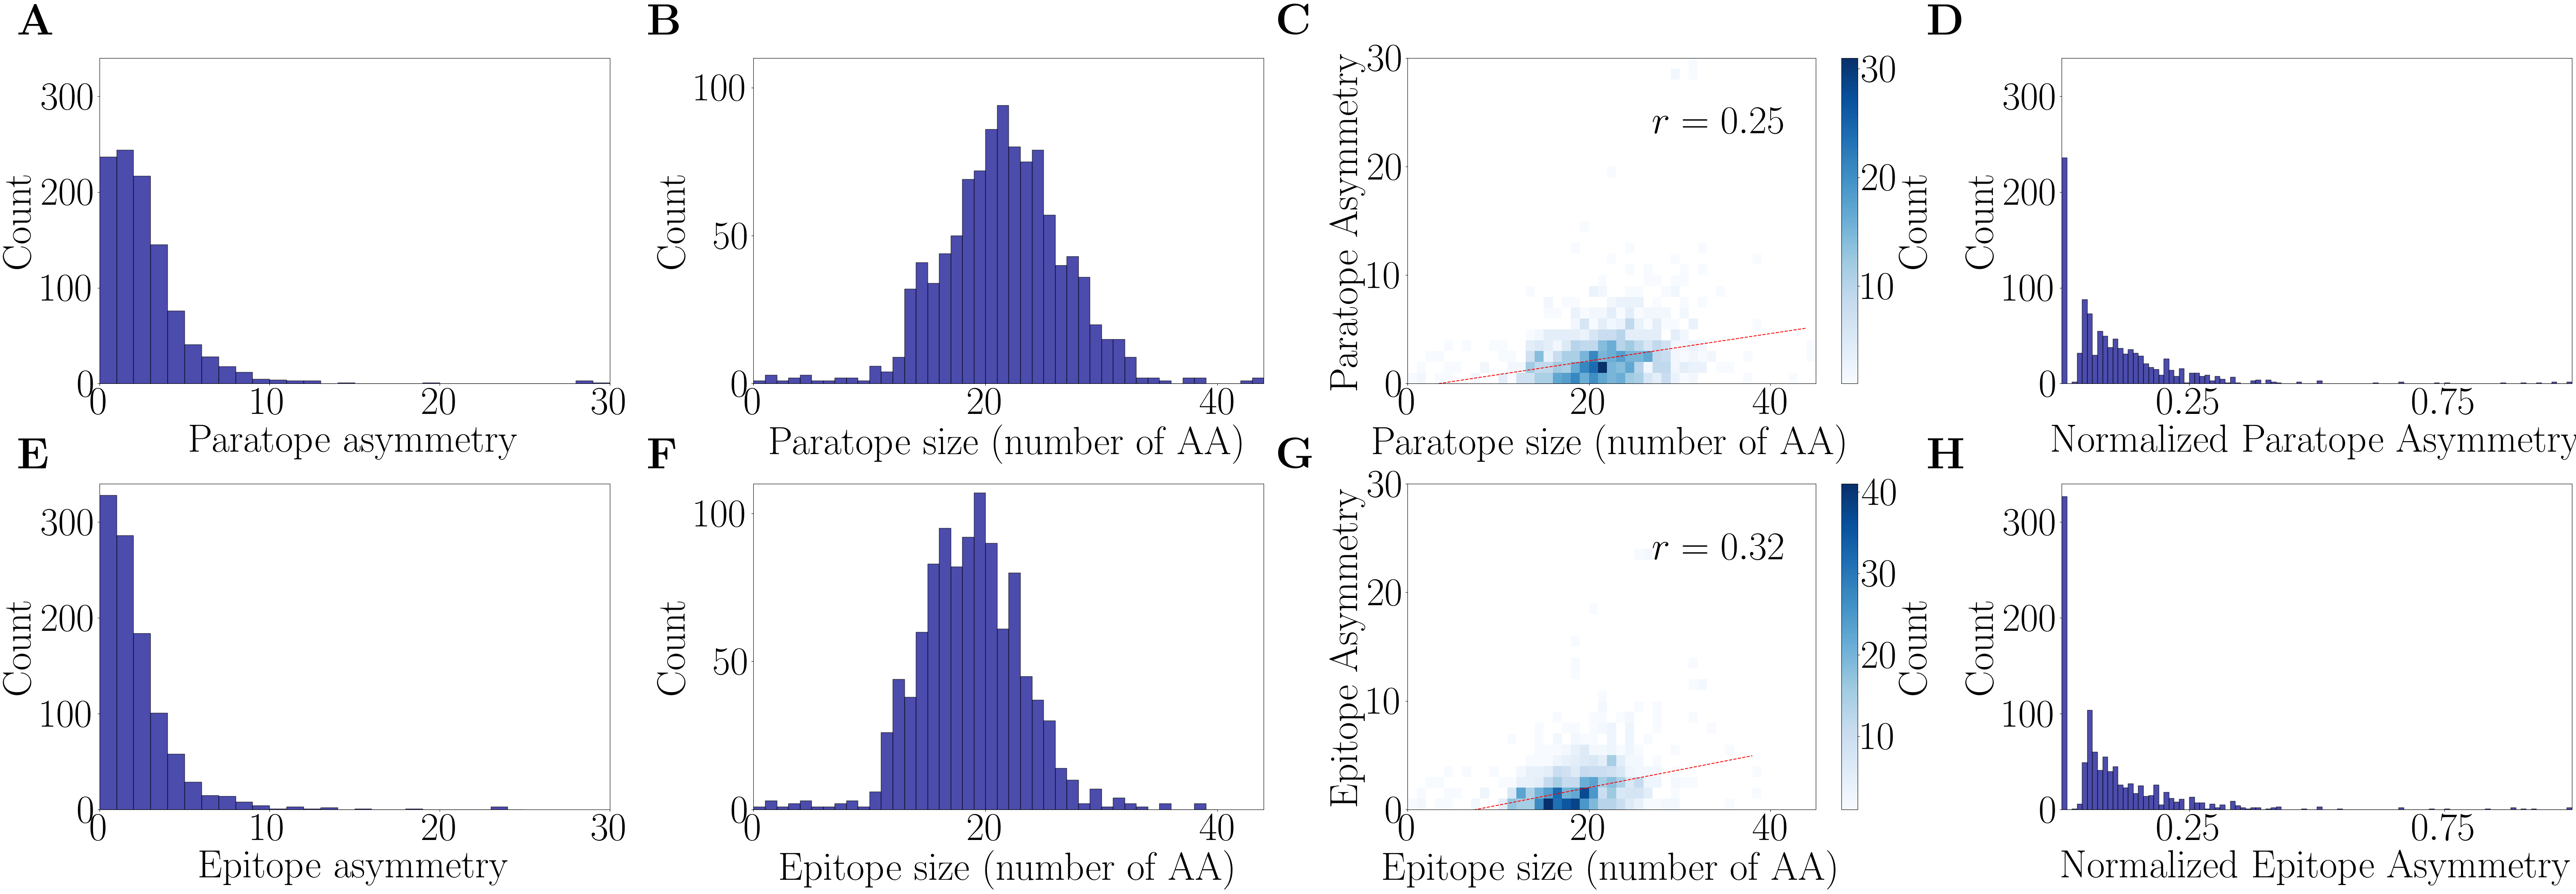

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(50, 24))

# Adjust the subplot parameters to give more space at the top
plt.subplots_adjust(top=0.85)

# Plot A: Histogram
axes[0, 0].hist(data_filtered["error_paratope"], bins=np.linspace(0, 30, 31), edgecolor='black', alpha=0.7, color="darkblue")
axes[0, 0].set_xlabel("Paratope asymmetry")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xlim([0, 30])
axes[0, 0].set_ylim([0, 340])

# Plot B: Histogram
axes[0, 1].hist(data_filtered["paratope_size"], bins=np.linspace(0, 44, 45), edgecolor='black', alpha=0.7, color="darkblue")
axes[0, 1].set_xlabel("Paratope size (number of AA)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xlim([0, 44])
axes[0, 1].set_ylim([0, 110])

# Plot D: Histogram
axes[0, 3].hist(data_filtered["normalized_error_paratope"], bins=np.linspace(0, 1, 101), edgecolor='black', alpha=0.7, color="darkblue")
axes[0, 3].set_xlabel("Normalized Paratope Asymmetry")
axes[0, 3].set_ylabel("Count")
axes[0, 3].set_xlim([0, 1])
axes[0, 3].set_ylim([0, 340])
axes[0, 3].set_xticks([0.25, 0.75])

# Plot E: Histogram
axes[1, 0].hist(data_filtered["error_antigen"], bins=np.linspace(0, 25, 26), edgecolor='black', alpha=0.7, color="darkblue")
axes[1, 0].set_xlabel("Epitope asymmetry")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_xlim([0, 30])
axes[1, 0].set_ylim([0, 340])

# Plot F: Histogram
axes[1, 1].hist(data_filtered["epitope_size_antigen"], bins=np.linspace(0, 40, 41), edgecolor='black', alpha=0.7, color="darkblue")
axes[1, 1].set_xlabel("Epitope size (number of AA)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xlim([0, 44])
axes[1, 1].set_ylim([0, 110])

# Plot H: Histogram
axes[1, 3].hist(data_filtered["normalized_error_epitope"], bins=np.linspace(0, 1, 101), edgecolor='black', alpha=0.7, color="darkblue")
axes[1, 3].set_xlabel("Normalized Epitope Asymmetry")
axes[1, 3].set_ylabel("Count")
axes[1, 3].set_xlim([0, 1])
axes[1, 3].set_ylim([0, 340])
axes[1, 3].set_xticks([0.25, 0.75])

# Add letters above each subplot
fig.text(0.01, 0.915, r'\textbf{A}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of Column 1
fig.text(0.32, 0.915, r'\textbf{B}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of Column 2
fig.text(0.63, 0.915, r'\textbf{C}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of 1st row, Column 3
fig.text(0.95, 0.915, r'\textbf{D}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of 2nd row, Column 3
fig.text(0.01, 0.47, r'\textbf{E}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of Column 1
fig.text(0.32, 0.47, r'\textbf{F}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of Column 2
fig.text(0.63, 0.47, r'\textbf{G}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of 1st row, Column 3
fig.text(0.95, 0.47, r'\textbf{H}', fontsize=78, fontweight='bold', va='top', ha='left')  # Top left of 2nd row, Column 3

# --- Plot C: Heatmap with regression line and Pearson r ---
x_c = data_filtered["paratope_size"]
y_c = data_filtered["error_paratope"]

# Heatmap with white background for 0 counts
h_c = axes[0, 2].hist2d(
    x_c, y_c,
    bins=[np.linspace(0, 45, 46), np.linspace(0, 30, 31)],
    cmap='Blues',
    cmin=1  # ignore bins with 0 count, so background stays white
)

# Add colorbar
cb_c = plt.colorbar(h_c[3], ax=axes[0, 2])
cb_c.set_label("Count")

# Regression line
slope_c, intercept_c, r_value_c, _, _ = stats.linregress(x_c, y_c)
x_line_c = np.linspace(x_c.min(), x_c.max(), 500)
y_line_c = slope_c * x_line_c + intercept_c
axes[0, 2].plot(x_line_c, y_line_c, color='red', linestyle='--')

# Pearson r
axes[0, 2].text(
    0.6, 0.85,
    f"$r = {r_value_c:.2f}$",
    transform=axes[0, 2].transAxes,
    fontsize=70,
    verticalalignment='top'
)

axes[0, 2].set_xlabel("Paratope size (number of AA)")
axes[0, 2].set_ylabel("Paratope Asymmetry")
axes[0, 2].set_xlim([0, 45])
axes[0, 2].set_ylim([0, 30])


# --- Plot G: Heatmap with regression line and Pearson r ---
x_g = data_filtered["epitope_size_antigen"]
y_g = data_filtered["error_antigen"]

h_g = axes[1, 2].hist2d(
    x_g, y_g,
    bins=[np.linspace(0, 45, 46), np.linspace(0, 30, 31)],
    cmap='Blues',
    cmin=1  # ignore 0s for transparency
)

cb_g = plt.colorbar(h_g[3], ax=axes[1, 2])
cb_g.set_label("Count")

slope_g, intercept_g, r_value_g, _, _ = stats.linregress(x_g, y_g)
x_line_g = np.linspace(x_g.min(), x_g.max(), 500)
y_line_g = slope_g * x_line_g + intercept_g
axes[1, 2].plot(x_line_g, y_line_g, color='red', linestyle='--')

axes[1, 2].text(
    0.6, 0.85,
    f"$r = {r_value_g:.2f}$",
    transform=axes[1, 2].transAxes,
    fontsize=70,
    verticalalignment='top'
)

axes[1, 2].set_xlabel("Epitope size (number of AA)")
axes[1, 2].set_ylabel("Epitope Asymmetry")
axes[1, 2].set_xlim([0, 45])
axes[1, 2].set_ylim([0, 30])

plt.tight_layout(rect=[0, 0, 1.27, 0.88])  # Adjust layout to prevent overlap
plt.savefig("/home/gabrielathenes/Dropbox/paratyping/second_draft/si_figures/si_figure2.pdf", bbox_inches='tight')
plt.show()